# 01 - Field reflectance analysis

This notebook loads, clean and visualices field reflectance data from different types of soil and vegetation. 

The data was obtained using the FieldSpec® 3 portable spectroradiometer. This instrument integrates three sensors, enabling measurements across a wide spectral range—from the visible to the near-infrared regions. It features precision optics with 25° and 10° field-of-view options and a fiber optic cable for collecting spectral data under different conditions. The device is equipped with a backpack for field use, a handheld probe for precise targeting, and dedicated software for instrument control and data analysis. Measurements are referenced against a Spectralon panel, which serves as a calibration target with near-100% reflectance.

Spectroradiometer sensor specifications:

| Sensor | Wavelength Range (nm) | Spectral Resolution (nm) | Sampling Interval (nm) |
|---------|------------------------|---------------------------|------------------------|
| NIR     | 400–1000               | 3                         | 1.4                    |
| SWIR1   | 1000–1800              | 10                        | 2                      |
| SWIR2   | 1800–2400              | 10                        | 2                      |



The objective of this exercise is to measure the spectral signature of different materials in the visible and near-infrared regions.

This notebook is organized to visualize and analyze field reflectance data from different types of soils, vegetation, and surfaces. The workflow is divided into several sections:


| Step | Description |
|:----:|:-------------|
| **1** | **Load raw spectral signatures** |
| **2** | **Clean spectral data** |
| **2.1** | **Visualize cleaned signatures by category** |
| **3** | **WV2 Band Comparison and Histogram Extraction** |
| **3.1** | **Data export and reuse** |



0. **Imports and setup**  
   All necessary Python packages and custom functions from `src/signatures_processing.py` are loaded here. The project folder is added to the Python path so the notebook can access the data and functions.




In [44]:
# ==============================================================================
# PATH CONFIGURATION 
# ==============================================================================

import sys
from pathlib import Path

# Add project root to sys.path
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
 

In [45]:
# Import the required libraries and codes from the project

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import json
import csv

# Import custom functions (paths configured in previous cell)
from src.signatures_processing import load_signatures_for_object


1. **Raw spectral signatures**  
   This section plots the mean spectral signatures of all objects directly from the raw measurement files. No cleaning or masking of bad bands is applied, and the reflectance is limited between 0 and 1 for proper visualization. The legend is omitted to keep the figure uncluttered.



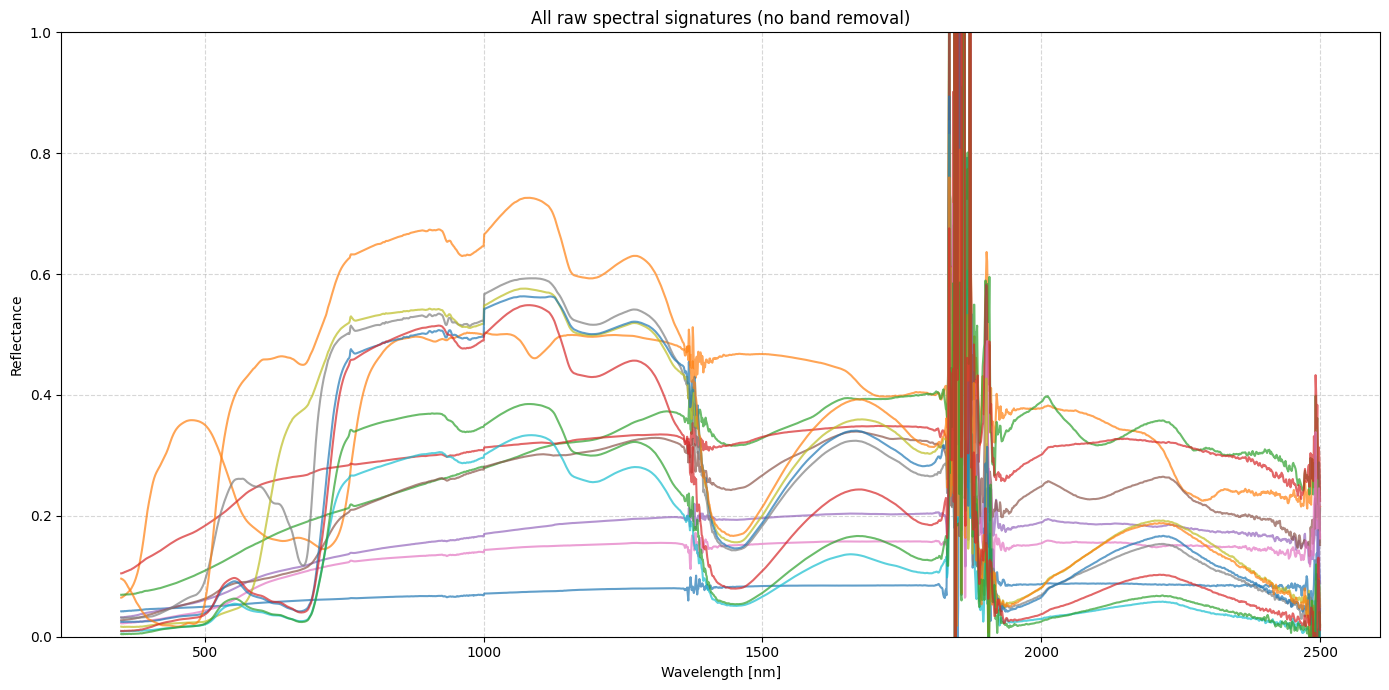

In [46]:

data_folder = Path('../data/field')

# Define all categories and objects
categories = {
    'surfaces': ['black_asphalt', 'blue_paint', 'wood_table', 'concrete'],
    'soils': ['soil', 'dry_grass', 'rough_soil'],
    'vegetation': ['lemon_leaf', 'red_flower', 'rosemary', 'jatropha', 'small_flower', 'weed', 'grass']
}






# Plot all raw signatures (without cleaning)
plt.figure(figsize=(14, 7))
for cat, objs in categories.items():
    for obj in objs:
        wl, mean_refl = load_signatures_for_object(data_folder, obj, clean=False)
        if wl is not None and mean_refl is not None:
            plt.plot(wl, mean_refl, alpha=0.7)
plt.title("All raw spectral signatures (no band removal)")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Reflectance")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



2. **Cleaned spectral signatures and category plots**  
   Here, the spectral data is processed using masks to remove noisy or invalid bands (e.g., atmospheric absorption regions).  
   - First, all cleaned signatures are plotted together with a legend.  
   - Then, separate plots for each category (surfaces, soils, vegetation) are generated to allow detailed inspection and comparison between objects within the same group.




C:\Users\Usuario\AppData\Roaming\Python\Python314\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


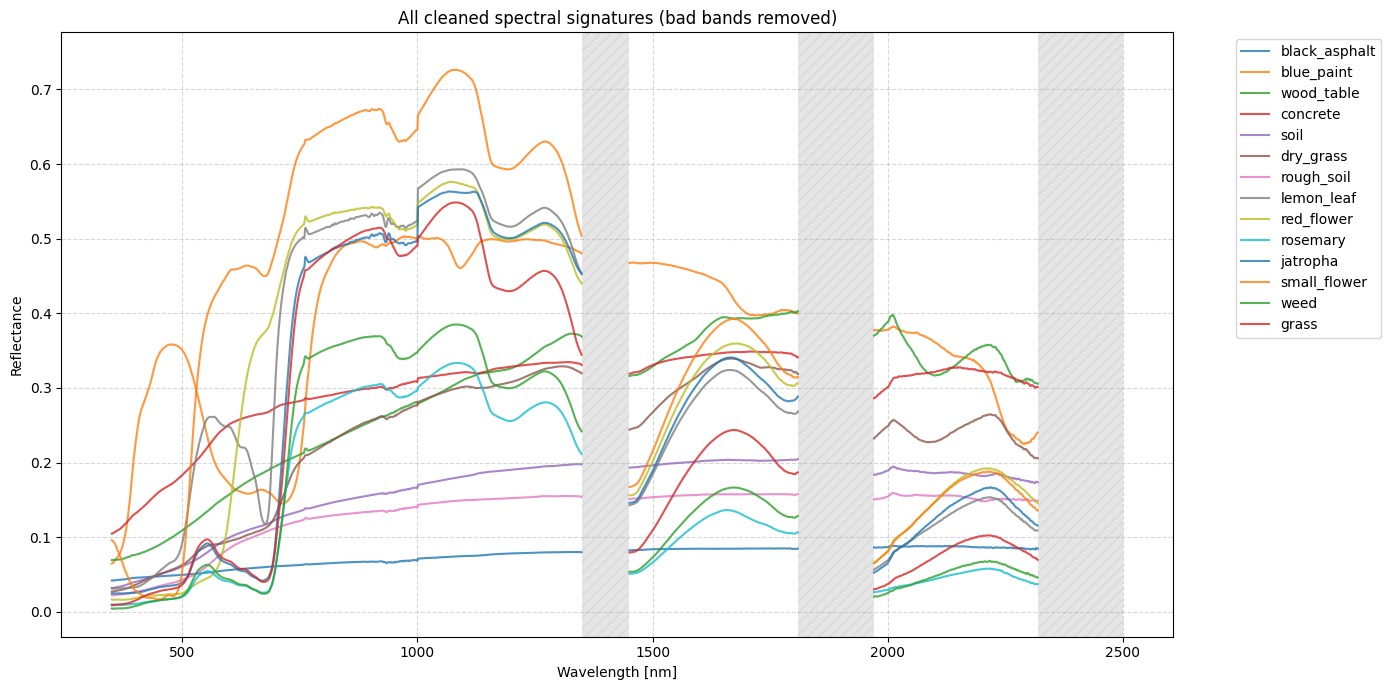

In [47]:
def add_atmospheric_bands_shading():
    """Adds gray shaded regions with diagonal hatching for atmospheric absorption bands"""
    from src.signatures_processing import get_atmospheric_bands
    bands = get_atmospheric_bands()
    
    for start, end in bands:
        plt.axvspan(start, end, alpha=0.2, facecolor='gray', 
                   hatch='///', edgecolor='darkgray', linewidth=0, zorder=0)


# Plot all cleaned signatures (with bad bands removed) WITH STANDARD DEVIATION
plt.figure(figsize=(14, 7))
for cat, objs in categories.items():
    for obj in objs:
        wl, mean_refl, std_refl = load_signatures_for_object(data_folder, obj, clean=True, return_std=True)
        if wl is not None and mean_refl is not None:
            line = plt.plot(wl, mean_refl, label=obj, alpha=0.8)
            color = line[0].get_color()
            plt.fill_between(wl, mean_refl - std_refl, mean_refl + std_refl, 
                            alpha=0.0, color=color)
plt.title("All cleaned spectral signatures (bad bands removed)")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Reflectance")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
add_atmospheric_bands_shading()
plt.tight_layout()
plt.show()


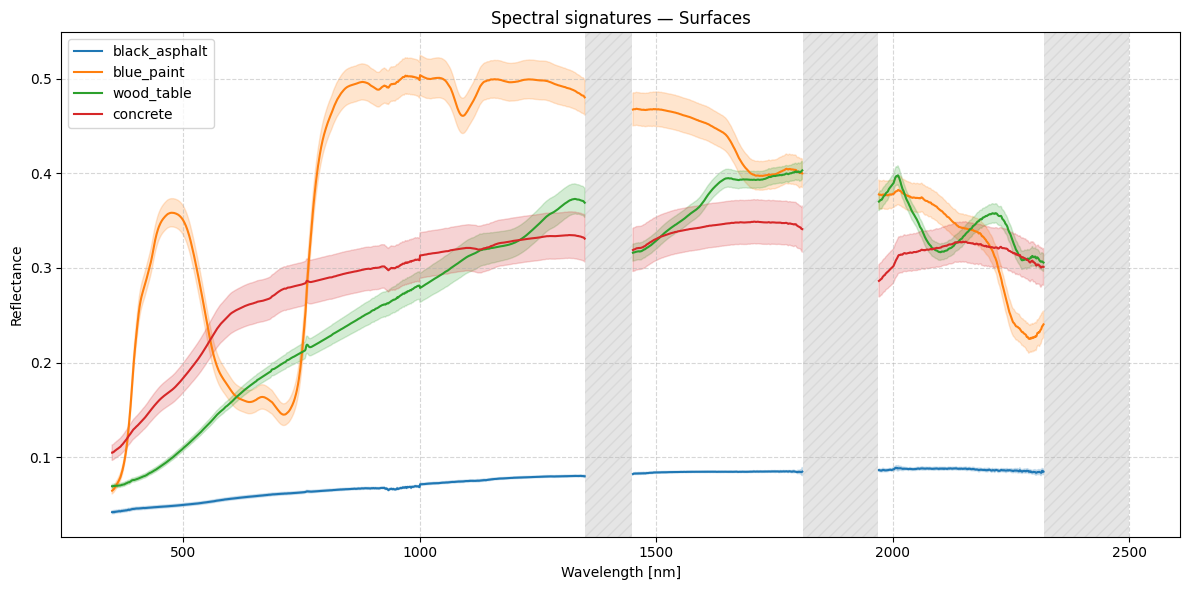

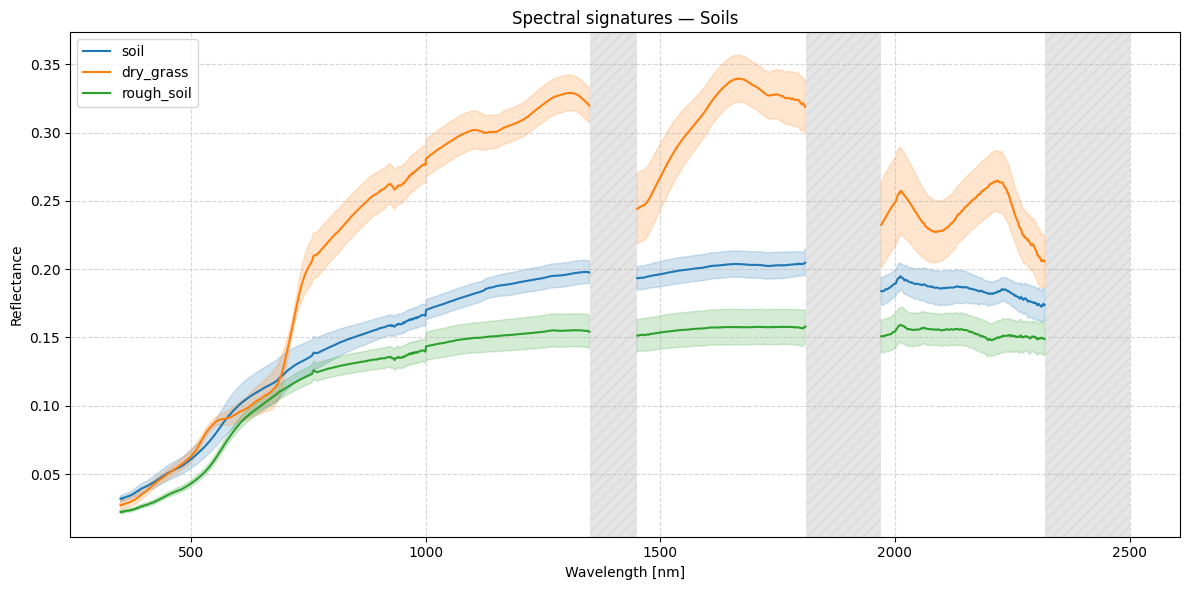

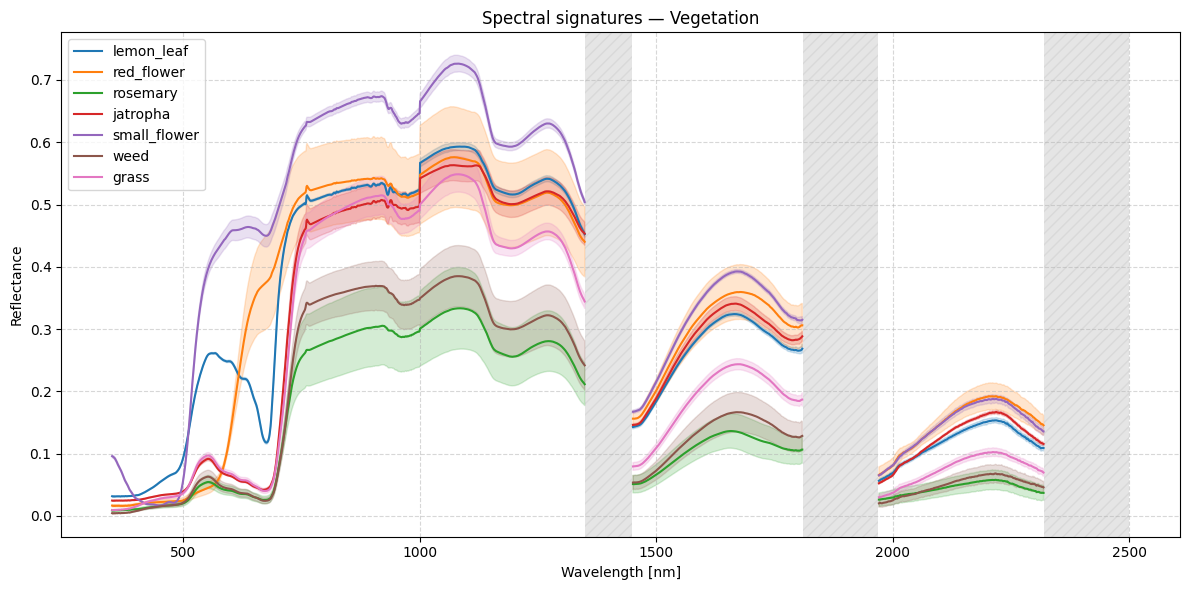

In [48]:
# Plot by category
def plot_category(category_name, object_list):
    plt.figure(figsize=(12, 6))
    for obj in object_list:
        wl, mean_refl, std_refl = load_signatures_for_object(data_folder, obj, clean=True, return_std=True)
        if wl is not None:
            line = plt.plot(wl, mean_refl, label=obj)
            color = line[0].get_color()
            plt.fill_between(wl, mean_refl - std_refl, mean_refl + std_refl, 
                            alpha=0.2, color=color)
    plt.title(f"Spectral signatures — {category_name.capitalize()}")
    plt.xlabel("Wavelength [nm]")
    plt.ylabel("Reflectance")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    add_atmospheric_bands_shading()
    plt.tight_layout()
    plt.show()




# Plot each group
for cat, objs in categories.items():
    plot_category(cat, objs)


3.  **WV2 bands vs spectral signatures**

This section compares cleaned field spectral signatures with the WorldView‑2 (WV2) spectral response functions, grouped by material type (Vegetation, Urban Surfaces, Soils).

- Left panel: spectral curves per object with shaded WV2 band responses for context. Standard deviation bands indicate intra-object variability.
- Right panel: bar chart of reflectance values sampled at the WV2 band centers for the same objects.

The sampled reflectance values are also saved for later use in `notebooks/surfaces_data/histogram_reflectances.json` and `notebooks/surfaces_data/histogram_reflectances.csv`. Run the next cell to generate the figures and files.


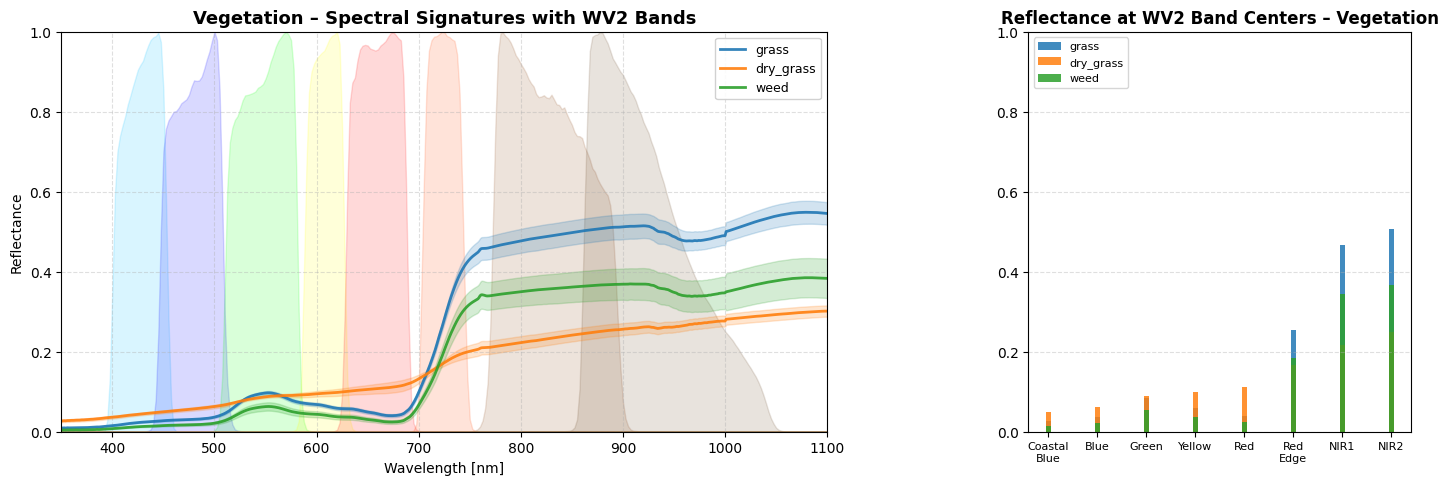

C:\Users\Usuario\AppData\Roaming\Python\Python314\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


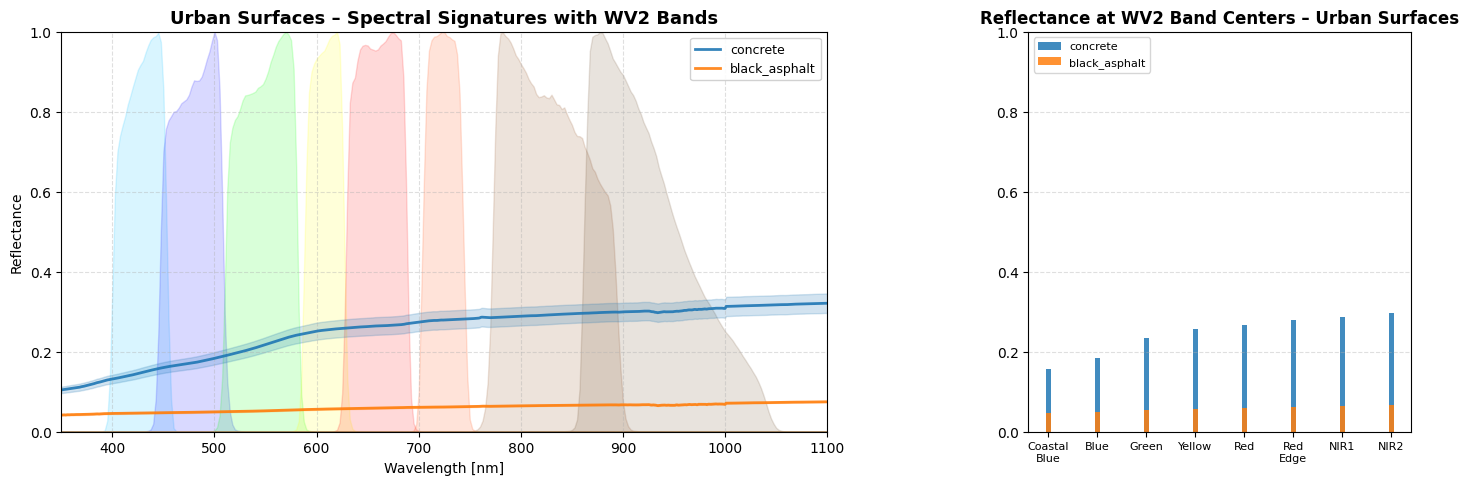

C:\Users\Usuario\AppData\Roaming\Python\Python314\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


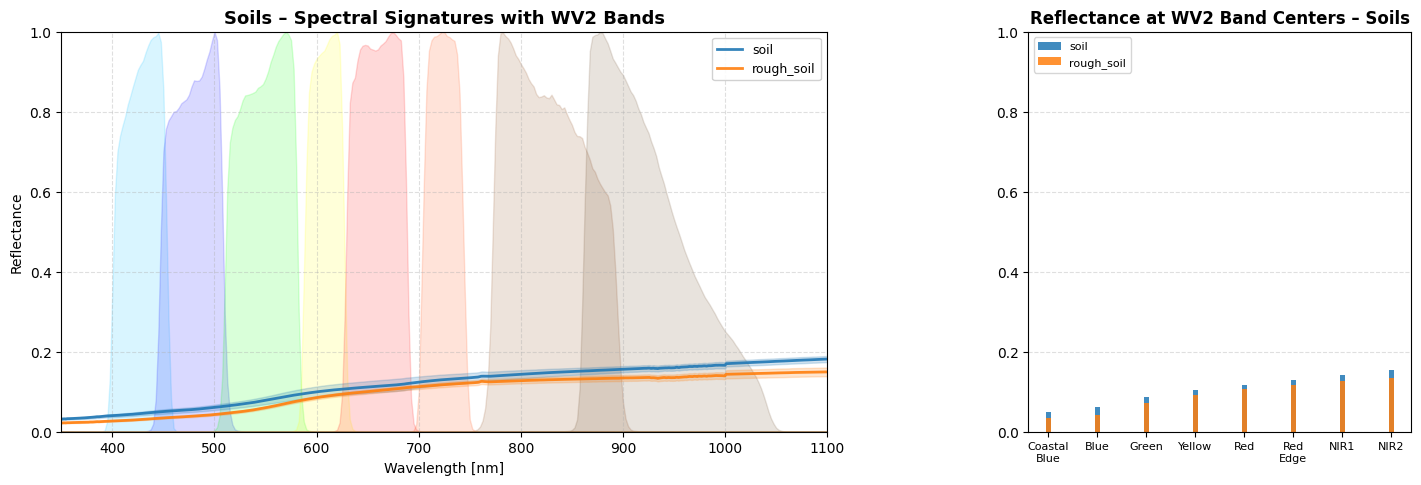

In [49]:
# ==============================================================================
# GROUPED PLOTS: WV2 BANDS VS SPECTRAL SIGNATURES
# ==============================================================================

from src.signatures_processing import load_wv2_bands

# Define groups of objects
object_groups = {
    "Vegetation": ['grass', 'dry_grass', 'weed'],
    "Urban Surfaces": ['concrete', 'black_asphalt'],
    "Soils": ['soil', 'rough_soil']
}


histogram_data = {}


# Load WV2 bands
wv2_wl, wv2_bands = load_wv2_bands('data/satellite/WV2.txt')

if wv2_wl is not None:
    # Calculate WV2 band centers
    mask_wv2 = wv2_wl <= 1150
    band_centers = {
        name: wv2_wl[mask_wv2][np.argmax(band[mask_wv2])]
        for name, band in wv2_bands.items()
    }

    band_names = list(band_centers.keys())
    x_pos = np.arange(len(band_names))
    colors_wv2 = ['#00BFFF', '#0000FF', '#00FF00', '#FFFF00', '#FF0000', '#FF4500', '#8B4513', '#654321']

    # Loop through each group
    for group_name, objects in object_groups.items():
        fig = plt.figure(figsize=(15, 5))
        gs = fig.add_gridspec(1, 2, width_ratios=[2, 1], wspace=0.35)
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])

        # --- LEFT: Spectral curves ---
        for i, (band_name, band_response) in enumerate(wv2_bands.items()):
            ax1.fill_between(wv2_wl[mask_wv2], 0, band_response[mask_wv2],
                             alpha=0.15, color=colors_wv2[i])

        for obj in objects:
            wl, mean_refl, std_refl = load_signatures_for_object(data_folder, obj, clean=True, return_std=True)

            # --- Skip empty or invalid data ---
            if wl is None or np.isnan(mean_refl).all():
                print(f"⚠️ Skipping {obj}: no valid data.")
                continue

            mask = wl <= 1100
            wl = wl[mask]
            mean_refl = mean_refl[mask]
            std_refl = std_refl[mask]

            line = ax1.plot(wl, mean_refl, label=obj, linewidth=2, alpha=0.9)
            color = line[0].get_color()
            ax1.fill_between(wl, mean_refl - std_refl, mean_refl + std_refl, alpha=0.2, color=color)

            # --- Histogram (RIGHT) ---
            reflectances = []
            for band_name in band_names:
                center_wl = band_centers[band_name]
                idx = np.argmin(np.abs(wl - center_wl))
                reflectances.append(mean_refl[idx])
            
            histogram_data[obj] = {band: float(reflectances[i]) for i, band in enumerate(band_names)}


            ax2.bar(x_pos, reflectances, width=0.1, label=obj, color=color, alpha=0.85)

        # --- Style ---
        ax1.set_title(f"{group_name} – Spectral Signatures with WV2 Bands", fontsize=13, fontweight='bold')
        ax1.set_xlabel('Wavelength [nm]')
        ax1.set_ylabel('Reflectance')
        ax1.set_xlim(350, 1100)
        ax1.set_ylim(0, 1)
        ax1.grid(True, linestyle='--', alpha=0.4)
        ax1.legend(fontsize=9, framealpha=0.9)

        ax2.set_title(f"Reflectance at WV2 Band Centers – {group_name}", fontsize=12, fontweight='bold')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels([b.replace(' ', '\n') for b in band_names], fontsize=8)
        ax2.set_ylim(0, 1)
        ax2.grid(True, axis='y', linestyle='--', alpha=0.4)
        ax2.legend(fontsize=8, loc='upper left')

        # Fix layout issues (avoids tight_layout warnings)
        plt.subplots_adjust(left=0.07, right=0.97, top=0.9, bottom=0.1)
        plt.show()


else:
    print("⚠️ Could not load WV2 data. Skipping WV2 comparison plots.")





In [50]:

# Save values for each object for later

out_dir = Path("surfaces_data")
out_dir.mkdir(exist_ok=True)

output_json = out_dir / "histogram_reflectances.json"
output_csv  = out_dir / "histogram_reflectances.csv"

# Save JSON
with open(output_json, "w", encoding="utf-8") as f:
    json.dump(histogram_data, f, indent=4, ensure_ascii=False)

# Save CSV
with open(output_csv, "w", newline='', encoding="utf-8") as f:
    writer = csv.writer(f)
    header = ["Object"] + band_names
    writer.writerow(header)
    for obj, vals in histogram_data.items():
        row = [obj] + [vals.get(b, "") for b in band_names]
        writer.writerow(row)

